In [11]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


In [12]:
TRAIN_DIR = 'UCI HAR Dataset/train'
TEST_DIR = 'UCI HAR Dataset/test'

def read_a_file(file):
    """
    read_a_file: Read the data file, Each row is corresponding to one subject's motion. 
    file: the file path
    
    """
    f = open(file, 'r', encoding='utf-8')
    data = []
    for line in f:
        line = line.strip().split()
        x = [float(v) for v in line]
        data.append(x)
    f.close()
    data = np.array(data)
    return data

In [13]:
def read_dataset(data_dir):
    """
    read_dataset: Read X and y form 'UCI HAR Dataset/train' or 'UCI HAR Dataset/test' . The returned X and y are used
    as training or testing data set.

    data_dir: file address 'UCI HAR Dataset/train' or 'UCI HAR Dataset/test'
     X (A n * f matrix,where n is the number of samples, f is the number of features),
     y (A n*1 matrix where n is corresponding to the number of labels)
    """
    kind = 'train' if 'train' in data_dir else 'test'

    # X has 2 parts: for train, it comes form X_train.txt, and Inertial Signals
    # Part 1. X_train.txt or X_test.txt
    X1 = read_a_file(os.path.join(data_dir, 'X_{}.txt'.format(kind)))
    print('The data shape of X_{}.txt is {} × {}'.format(kind, X1.shape[0], X1.shape[1]))

    
    # Part 2. Inertial Signals
    # IS_dir = os.path.join(data_dir, 'Inertial Signals')
    # X2 = []
    # for file_name in os.listdir(IS_dir):
    #     file_path = os.path.join(IS_dir, file_name)
    #     tmp = read_a_file(file_path)
    #     X2.append(tmp)
    # X2 = np.concatenate(X2, axis=1)
    # print('The data shape of Inertial Signals is {} × {}'.format(X2.shape[0], X2.shape[1]))

    # X = np.concatenate([X1, X2], axis=1)
    
    X = X1
  
    # Read the y data
    y = read_a_file(os.path.join(data_dir, 'y_{}.txt'.format(kind)))
    y = y.reshape(-1)
    y = [int(v) for v in y]
    return X, y

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(561, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 6)
    
    def forward(self, x):
        x = x.view(-1, 561)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

The data shape of X_train.txt is 7352 × 561

The data shape of X_test.txt is 2947 × 561

epoch: 1 ,round:  1000 , loss: 1.507
epoch: 1 ,round:  2000 , loss: 1.283
epoch: 1 ,round:  3000 , loss: 1.057
epoch: 1 ,round:  4000 , loss: 1.015
epoch: 1 ,round:  5000 , loss: 0.986
epoch: 1 ,round:  6000 , loss: 0.803
epoch: 1 ,round:  7000 , loss: 0.865
epoch: 2 ,round:  1000 , loss: 0.607
epoch: 2 ,round:  2000 , loss: 0.637
epoch: 2 ,round:  3000 , loss: 0.353
epoch: 2 ,round:  4000 , loss: 0.569
epoch: 2 ,round:  5000 , loss: 0.401
epoch: 2 ,round:  6000 , loss: 0.338
epoch: 2 ,round:  7000 , loss: 0.333
epoch: 3 ,round:  1000 , loss: 0.326
epoch: 3 ,round:  2000 , loss: 0.449
epoch: 3 ,round:  3000 , loss: 0.310
epoch: 3 ,round:  4000 , loss: 0.516
epoch: 3 ,round:  5000 , loss: 0.299
epoch: 3 ,round:  6000 , loss: 0.389
epoch: 3 ,round:  7000 , loss: 0.276
epoch: 4 ,round:  1000 , loss: 0.264
epoch: 4 ,round:  2000 , loss: 0.315
epoch: 4 ,round:  3000 , loss: 0.354
epoch: 4 ,round:  4000 

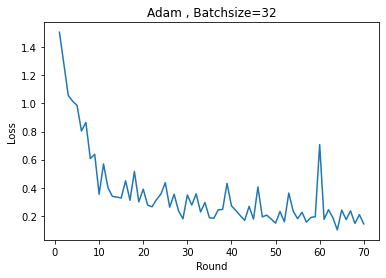

Error rate of the network on the test set: 12.487275 %


In [15]:
if __name__ == '__main__':
    #data process
    #train data
    X_train, y_train = read_dataset(TRAIN_DIR)
    
    X_train = torch.tensor(X_train, dtype=torch.float32)  #transfer numpy to tensor
    y_train = [ y-1 for y in y_train ]   #Reset labels as 0 to 5
    y_train = torch.tensor(y_train)  #transfer numpy to tensor
    
    my_dataset = data.TensorDataset(X_train,y_train) # create my datset
    my_dataloader = data.DataLoader(my_dataset) # create my dataloader
    train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=16, shuffle=True)
    
    print()
    #test data
    X_test, y_test = read_dataset(TEST_DIR)
    y_test = [ y-1 for y in y_test ] #Reset labels as 0 to 5
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test)
    my_testdataset = data.TensorDataset(X_test,y_test)
    my_testdataloader = data.DataLoader(my_testdataset)
    print()
    
    #train
    net = Net()
    #choose Cross Entropy Loss as my loss function 
    criterion = nn.CrossEntropyLoss()
    #choose Stochastic Gradient Descent to updated parameters.
    #set the learning rate to 0.001; set the momentum to 0.9 which may help jump out of local optimum
#     optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
    optimizer = optim.Adam(net.parameters())
    
    #log loss data for plotting
    cnt = 0
    x=[]
    y=[]
    
    for epoch in range(10):
        running_loss = 0.0
        for i, data in enumerate(my_dataloader, 0):
            inputs, labels = data
            
            optimizer.zero_grad()#initialize the gradient of each variable
            outputs = net(inputs) #forward-propagating process
            loss = criterion(outputs, labels) #compute the loss function
            loss.backward()  #back-propagation
            optimizer.step() #update the parameters
            
            running_loss += loss.item()
            if i % 1000 == 999:
                cnt += 1
                x.append(cnt)
                y.append(running_loss / 1000)
                print('epoch: %d ,round: %5d , loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0
                
    plt.plot(x, y)
    plt.xlabel("Round")
    plt.ylabel("Loss")
    plt.title("Adam , Batchsize=32") 
    plt.show()
                
    #Test model performance with test data
    correct = 0
    total = 0
    with torch.no_grad():
        for data in my_testdataloader:
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Error rate of the network on the test set: %f %%' % (100-100 * correct / total))
    